In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the data into arrays
# first column of the data file is phase data
WHT_PhaseHalf = np.loadtxt("GD356WHT.dat", usecols=(0))
WHT_Phase = np.concatenate((WHT_PhaseHalf, WHT_PhaseHalf+1))
# second column of the data file is flux data
WHT_FluxHalf = np.loadtxt("GD356WHT.dat", usecols=(1))
WHT_Flux = np.concatenate((WHT_FluxHalf+1, WHT_FluxHalf+1))
# third column of the data file is flux error
WHT_ErrorHalf = np.loadtxt("GD356WHT.dat", usecols=(2))
WHT_Error = np.concatenate((WHT_ErrorHalf, WHT_ErrorHalf))

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

meanPhase, meanFlux, meanError = mean_data(WHT_Phase, WHT_Flux, WHT_Error, 200)


In [4]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [5]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

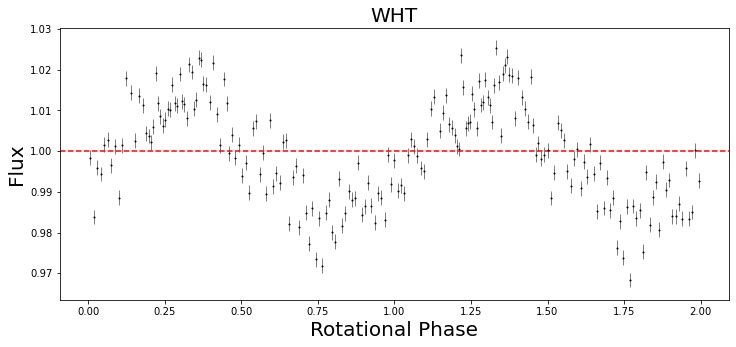

In [6]:
plt.figure(figsize=(12, 5))

plt.title('WHT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# Medium Radius

In [7]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.15, testval=0.13)
    radius = pm.Uniform("radius", lower=20.0, upper=60.0, testval=30.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)

    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [8]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -3562.5634126794557 -> -100.5991837278096


In [9]:
keys = ["contrast", "radius", "lat", "lon", "inc"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.14210
radius       57.93161
lat          77.33338
lon          68.56060
inc          53.20992


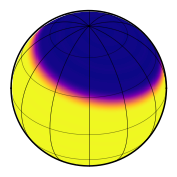

In [10]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.14210, radius=57.93161, lat=77.33338, lon=68.56060)
map.inc = 53.20992
map.show()

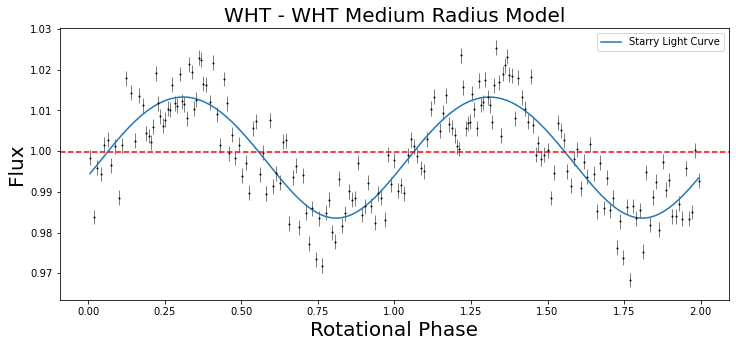

In [11]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('WHT - WHT Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [12]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

11.949007256634628

# Large Radius

In [13]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=0.15, testval=0.12)
    radius = pm.Uniform("radius", lower=60.0, upper=90.0, testval=70.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)

    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [14]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -3550.714256678977 -> -85.61088318029917


In [15]:
keys = ["contrast", "radius", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.08289
radius       88.22326
lat           7.58977
lon          68.32379
inc          20.25267


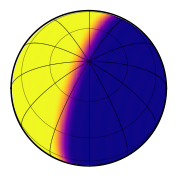

In [16]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.08289, radius=88.22326, lat=7.58977, lon=68.32379)
map.inc = 20.25267
map.show()

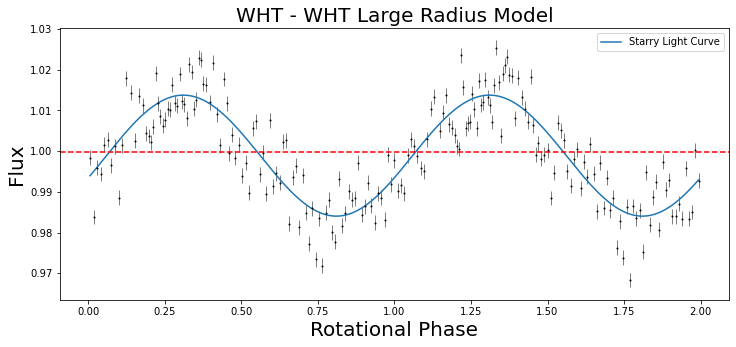

In [17]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('WHT - WHT Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [18]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

11.814316473930862

In [11]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.014495624012067776

# TESS - Medium Radius

In [18]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 20.52788
    lat = 47.71131
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 41.76645
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [19]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -11505.38640753832 -> -537.5507942169831


In [20]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.35688
lon          69.02258


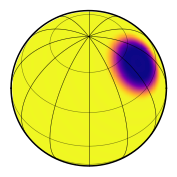

In [21]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.35688, radius=20.52788, lat=47.71131, lon=69.02258)
map.inc = 41.76645
map.show()

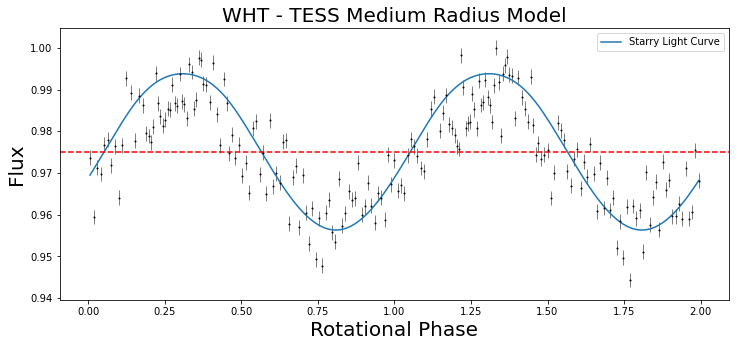

In [22]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - TESS Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [24]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

15.52042680086173

# TESS - Large Radius

In [31]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 89.64379
    lat = -44.26156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=69)
    inc = 24.04429
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [32]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -166922.61334522677 -> -623.0370489901559


In [33]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.13464
lon          68.26926


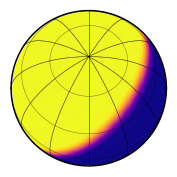

In [34]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.13464, radius=89.64379, lat=-44.26156, lon=68.26926)
map.inc = 24.04429
map.show()

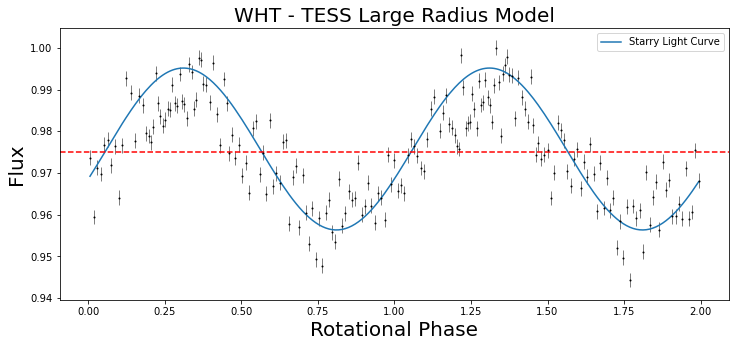

In [35]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - TESS Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [37]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

16.318060522459714

In [14]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.01914937582147408

# LT - Medium Radius

In [38]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 21.43014
    lat = 48.30740
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=69)
    inc = 40.38516
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [39]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -6988.268475157303 -> -373.7694992354103


In [40]:
keys = ["contrast","lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.32504
lon          68.88754


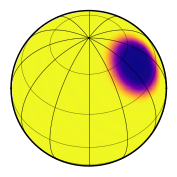

In [41]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.32504, radius=21.43014, lat=48.30740, lon=68.88754)
map.inc = 40.38516
map.show()

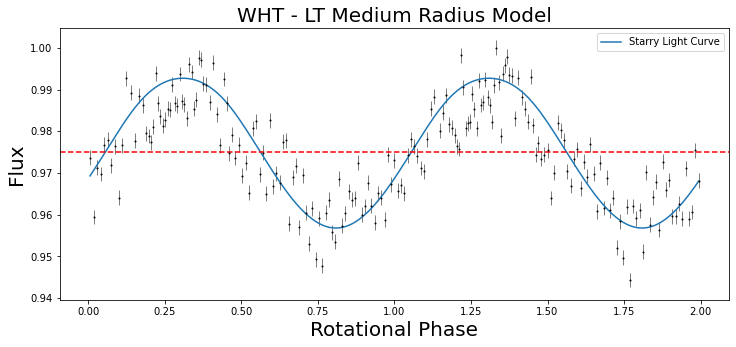

In [42]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - LT Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [44]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

13.969841941279332

# LT - Small Radius

In [45]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 10.99128
    lat = 45.37503
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=69)
    inc = 36.94310
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [46]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -8120.078112783497 -> -1013.7193982860585


In [47]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.99984
lon          68.63242


In [48]:
keys = ["contrast","lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.99984
lon          68.63242


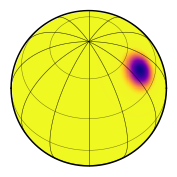

In [49]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.99984, radius=10.99128, lat=45.37503, lon=68.63242)
map.inc = 36.94310
map.show()

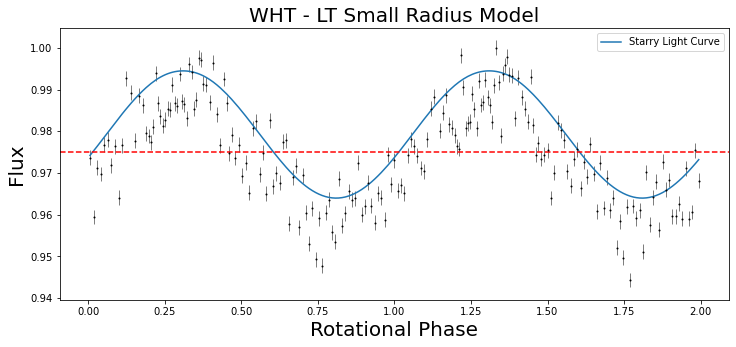

In [50]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - LT Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [51]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

20.090883706774516

# LT - Large Radius

In [52]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 88.96745
    lat = -42.93086
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=69)
    inc = 21.40506
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [53]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -149197.64921764177 -> -391.97999439916725


In [54]:
keys = ["contrast","lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.14069
lon          68.30440


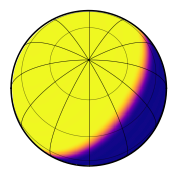

In [55]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.14069, radius=88.96745, lat=-42.93086, lon=68.30440)
map.inc = 21.40506
map.show()

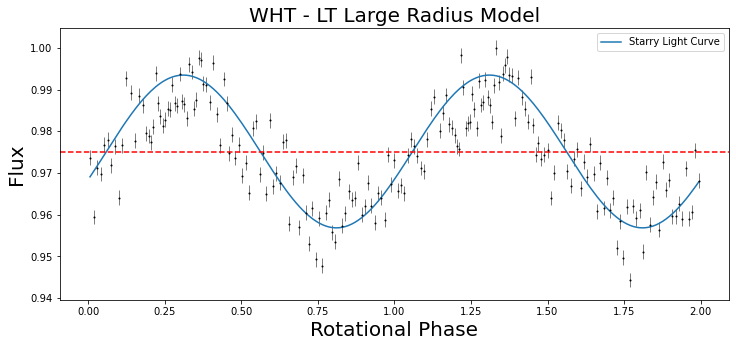

In [56]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - LT Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [57]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

14.131912603614394

In [58]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.018308936051076807

# PTO - Small Radius

In [59]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 13.11429
    lat = 44.35413
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=69)
    inc = 37.85545
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [60]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -4457.615075232176 -> -556.3379566857676


In [61]:
keys = ["contrast","lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.85478
lon          68.63401


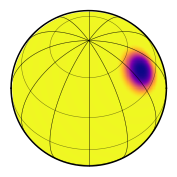

In [62]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.85478, radius=13.11429, lat=44.35413, lon=68.63401)
map.inc = 37.85545
map.show()

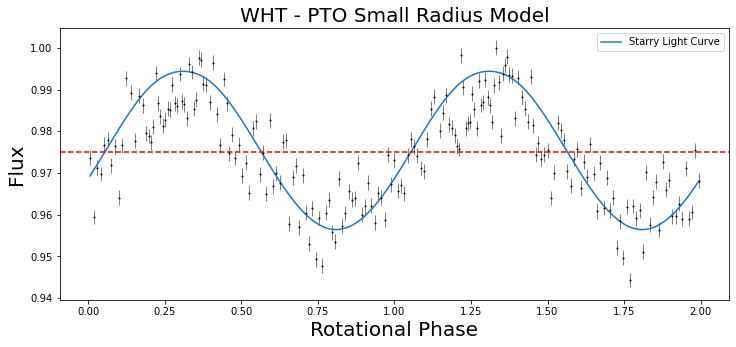

In [63]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - PTO Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [64]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

15.684078636921699

In [20]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.01884828815102879

# PTO - Medium Radius

In [65]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 23.28693
    lat = 46.48269
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 40.46170
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [66]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -23888.142474222102 -> -493.6365458020168


In [67]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.28063
lon          69.04565


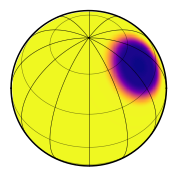

In [68]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.28063, radius=23.28693, lat=46.48269, lon=69.04565)
map.inc = 40.46170
map.show()

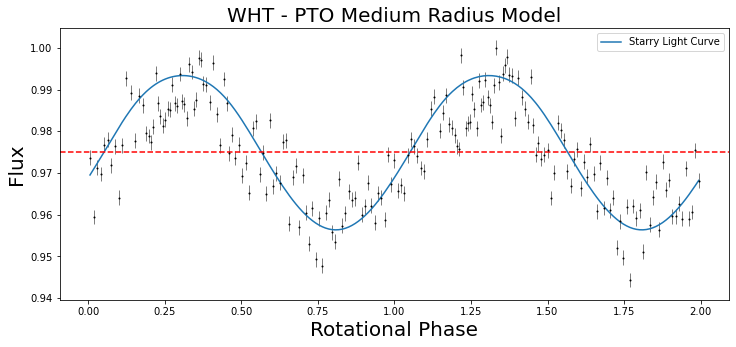

In [69]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - PTO Medium Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [70]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

15.107716211418905

# PTO - Large Radius

In [74]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 87.13632
    lat = -42.35981
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=69)
    inc = 22.28141
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [75]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -134159.93277393424 -> -563.0350643872699


In [76]:
keys = ["contrast","lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.14581
lon          68.40799


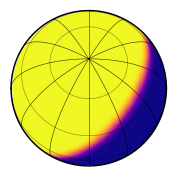

In [77]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.14581, radius=87.13632, lat=-42.35981, lon=68.40799)
map.inc = 22.28141
map.show()

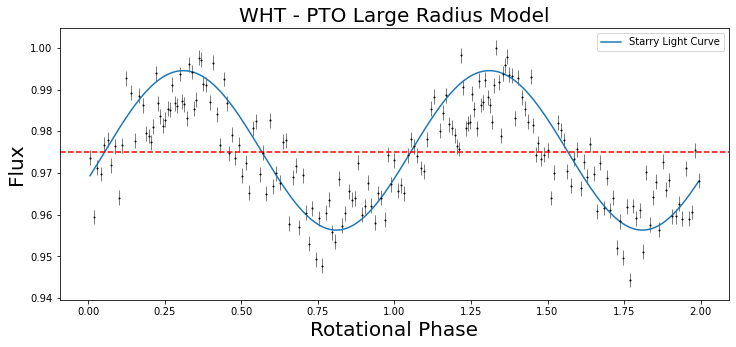

In [78]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.title('WHT - PTO Large Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

In [80]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/195
reduced

15.753152462223879

In [81]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.019112821961427162

# Brinkworth 2004

In [47]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 40
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=30.0)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=45.0)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=1.4)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [48]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, contrast]


message: Optimization terminated successfully.
logp: -198190.3884878904 -> -108.84715981694579


In [49]:
keys = ["contrast", "lat", "lon", "inc"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.42305
lat          -2.03936
lon          68.79157
inc          10.06363


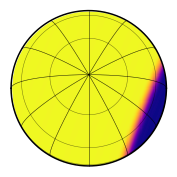

In [25]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.42305, radius=40, lat=-2.03936, lon=68.79157)
map.inc = 10.06363
map.show()

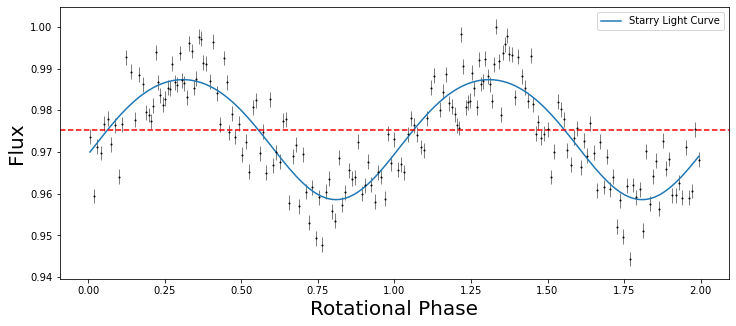

In [26]:
newFlux = map.flux(theta=theta)

plt.figure(figsize=(12, 5))

plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.median(flux), color='r', linestyle='--');

In [52]:
residuals = (flux - newFlux)/meanError
chi_squared = np.sum(residuals**2)
chi_squared

2255.492609680346

In [27]:
amplitude = (np.amax(newFlux) - np.amin(newFlux)) / 2
amplitude

0.014382987023195903